## IMPORTING NECESSARY LIBRARIES

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

## DEFINING PATH FOR DATASET

In [2]:
image_path = r'C:\Data\SRI\Chest XRay\images'
mask_path = r'C:\Data\SRI\Chest XRay\masks'

test_path = r'C:\Data\SRI\Chest XRay\test'

## GETTING TRAIN/VALIDATION DATA

In [3]:
mask_path_list = os.listdir(mask_path)
random.shuffle(mask_path_list)

images = []
masks = []
for row in mask_path_list:
    image_path1 = os.path.join(image_path, row)
    mask_path1 = os.path.join(mask_path, row)

    image_read = cv2.imread(image_path1, 1) 
    mask_read = cv2.imread(mask_path1, -1) 
    
    image_final = cv2.resize(image_read, (128, 128))        
    mask_final = cv2.resize(mask_read, (128, 128))
        
    images.append(image_final)
    masks.append(mask_final)

In [4]:
images = np.array(images)
masks = np.array(masks)

images = images/255
masks = masks/255

## TRAIN-VALIDATION SPLIT

In [5]:
train_images = images[:608]
train_masks = masks[:608]                            

In [6]:
valid_images = images[608:]
valid_masks = masks[608:]

## GETTING TEST DATA

In [7]:
test_path_list = os.listdir(test_path)

test_images = []
for row in test_path_list:
    test_path1 = os.path.join(image_path, row)

    test_read = cv2.imread(test_path1, 1) 
    
    test_final = cv2.resize(test_read, (128, 128))        

    test_images.append(test_final)
    
test_images = np.array(test_images)
test_images = test_images/255

## CONVOLUTION BLOCKS

In [8]:
#down sampling
def down_samp(x, filters):
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(x)
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(c)
    p = keras.layers.MaxPooling2D((2, 2), (2, 2))(c)
    
    return c, p
    
#bottleneck 
def bottlenock(x, filters):
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(x)
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(c)
    
    return c
    
#up sampling
def up_samp(x, skip, filters):
    us = keras.layers.UpSampling2D((2, 2))(x)
    conc = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(conc)
    c = keras.layers.Conv2D(filters, (3, 3), padding="same", strides=1, activation="relu")(c)
    
    return c

## UNET ARCHITECTURE

In [9]:
def unet():
    f = [8, 16, 32, 64, 128]
    
    inputs = keras.layers.Input((128, 128, 3))
    
    p0 = inputs
    c1, p1 = down_samp(p0, f[0])
    c2, p2 = down_samp(p1, f[1])
    c3, p3 = down_samp(p2, f[2])
    c4, p4 = down_samp(p3, f[3])
    
    bn = bottlenock(p4, f[4])
    
    d1 = up_samp(bn, c4, f[3])
    d2 = up_samp(d1, c3, f[2])
    d3 = up_samp(d2, c2, f[1])
    d4 = up_samp(d3, c1, f[0])
 
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    
    model = keras.models.Model(inputs, outputs)
    
    return model

In [10]:
model = unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 8)    0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## TRAINING THE UNET MODEL

In [12]:
model.fit(
    train_images,
    train_masks,
    epochs=5,
    validation_data=(valid_images, valid_masks),
)

Epoch 1/5
19/19 [==============================] - 42s 2s/step - loss: 0.5220 - accuracy: 0.7428 - val_loss: 0.4179 - val_accuracy: 0.7524
Epoch 2/5
19/19 [==============================] - 37s 2s/step - loss: 0.3587 - accuracy: 0.7703 - val_loss: 0.2725 - val_accuracy: 0.8925
Epoch 3/5
19/19 [==============================] - 36s 2s/step - loss: 0.2563 - accuracy: 0.8985 - val_loss: 0.1765 - val_accuracy: 0.9295
Epoch 4/5
19/19 [==============================] - 35s 2s/step - loss: 0.1349 - accuracy: 0.9463 - val_loss: 0.1100 - val_accuracy: 0.9561
Epoch 5/5
19/19 [==============================] - 35s 2s/step - loss: 0.1063 - accuracy: 0.9574 - val_loss: 0.0979 - val_accuracy: 0.9610


## PREDICTION ON TEST DATA

In [13]:
result = model.predict(test_images)

result = result < 0.5

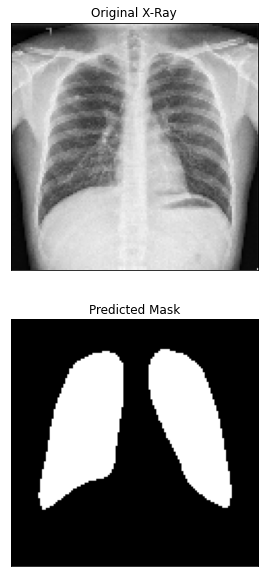

In [14]:
plt.figure(figsize = (10,10))

plt.subplot(2, 1, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(test_images[50], cmap='bone')
plt.title('Original X-Ray')

plt.subplot(2, 1, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(result[50], cmap='binary')
plt.title('Predicted Mask')

plt.show()